In [1]:
import pandas as pd

In [6]:
emitters = pd.read_csv(
    "../data/halpha_emitters-gustabin/SPLUS-s.csv"
)

In [4]:
emitters.columns

Index(['id', 'ra', 'dec', 'parallax', 'gaia_ruwe', 'gaia_parallax_over_error',
       'gaia_classprob_dsc_combmod_star', 'gaia_in_qso_candidates',
       'gaia_in_galaxy_candidates', 'gaia_phot_bp_rp_excess_factor',
       'mag_pstotal_r', 'mag_pstotal_i', 'mag_pstotal_u', 'mag_pstotal_g',
       'mag_pstotal_z', 'mag_pstotal_j0378', 'mag_pstotal_j0395',
       'mag_pstotal_j0410', 'mag_pstotal_j0430', 'mag_pstotal_j0515',
       'mag_pstotal_j0660', 'mag_pstotal_j0861', 'err_mag_pstotal_r',
       'err_mag_pstotal_i', 'err_mag_pstotal_u', 'err_mag_pstotal_g',
       'err_mag_pstotal_z', 'err_mag_pstotal_j0378', 'err_mag_pstotal_j0395',
       'err_mag_pstotal_j0410', 'err_mag_pstotal_j0430',
       'err_mag_pstotal_j0515', 'err_mag_pstotal_j0660',
       'err_mag_pstotal_j0861', 'EW_Ha', 'EW_Ha_err', 'SNR_EW', 'method'],
      dtype='object')

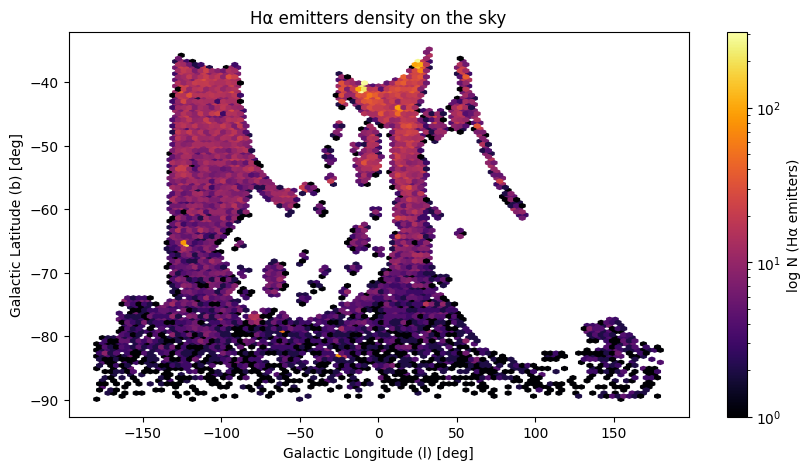

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u

# Example: your dataframe is called df
coords = SkyCoord(ra=emitters['ra'].values*u.deg, dec=emitters['dec'].values*u.deg, frame='icrs')
l = coords.galactic.l.wrap_at(180*u.deg).deg  # wrap to [-180, 180]
b = coords.galactic.b.deg

plt.figure(figsize=(10, 5))
plt.hexbin(l, b, gridsize=100, cmap='inferno', bins='log')
plt.colorbar(label='log N (Hα emitters)')
plt.xlabel('Galactic Longitude (l) [deg]')
plt.ylabel('Galactic Latitude (b) [deg]')
plt.title('Hα emitters density on the sky')
plt.show()

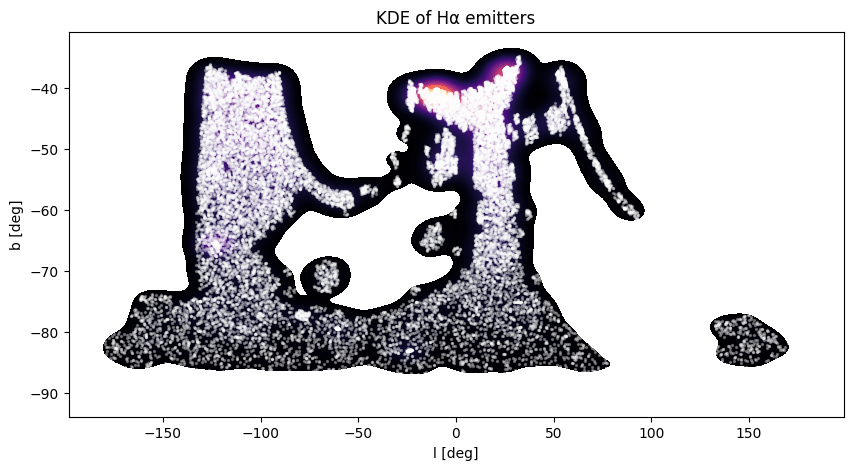

In [8]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.kdeplot(
    x=l,
    y=b,
    fill=True,
    cmap='magma',
    levels=50,
    bw_adjust=0.5,  # controls smoothing
)
plt.scatter(l, b, s=2, c='white', alpha=0.3)
plt.xlabel('l [deg]')
plt.ylabel('b [deg]')
plt.title('KDE of Hα emitters')
plt.show()

In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np

# Convert parallax [mas] to distance [pc]
distance_pc = 1000.0 / emitters["parallax"].astype(float)

coords = SkyCoord(
    ra=emitters["ra"].values * u.deg,
    dec=emitters["dec"].values * u.deg,
    distance=distance_pc * u.pc,
    frame="icrs"
).galactic

X = coords.cartesian.x.value
Y = coords.cartesian.y.value
Z = coords.cartesian.z.value

emitters["X_pc"] = X
emitters["Y_pc"] = Y
emitters["Z_pc"] = Z

R0 = 8200.0  # pc
Zsun = 20.0  # pc
emitters["X_gc"] = emitters["X_pc"] + R0
emitters["Y_gc"] = emitters["Y_pc"]
emitters["Z_gc"] = emitters["Z_pc"] + Zsun

In [10]:
R0 = 8200.0  # pc
Zsun = 20.0  # pc
emitters["X_gc"] = emitters["X_pc"] + R0
emitters["Y_gc"] = emitters["Y_pc"]
emitters["Z_gc"] = emitters["Z_pc"] + Zsun

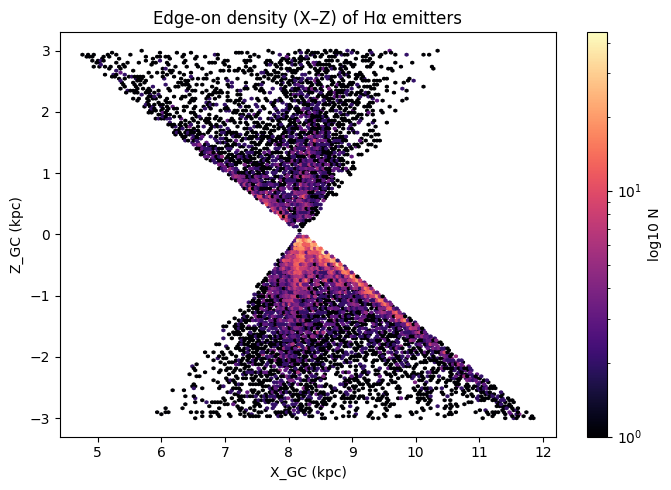

In [12]:
import matplotlib.pyplot as plt

df = emitters.copy()
Xk = df["X_gc"] / 1000.0
Zk = df["Z_gc"] / 1000.0

# trim for clarity
sel = (np.abs(Zk) < 3) & (np.abs(Xk) < 25)
Xk, Zk = Xk[sel], Zk[sel]

plt.figure(figsize=(7,5))
hb = plt.hexbin(Xk, Zk, gridsize=160, bins='log', cmap='magma')
cbar = plt.colorbar(hb); cbar.set_label('log10 N')
plt.axhline(0, color='white', lw=0.5, alpha=0.6)
plt.xlabel("X_GC (kpc)")
plt.ylabel("Z_GC (kpc)")
plt.title("Edge-on density (X–Z) of Hα emitters")
plt.tight_layout()
plt.show()

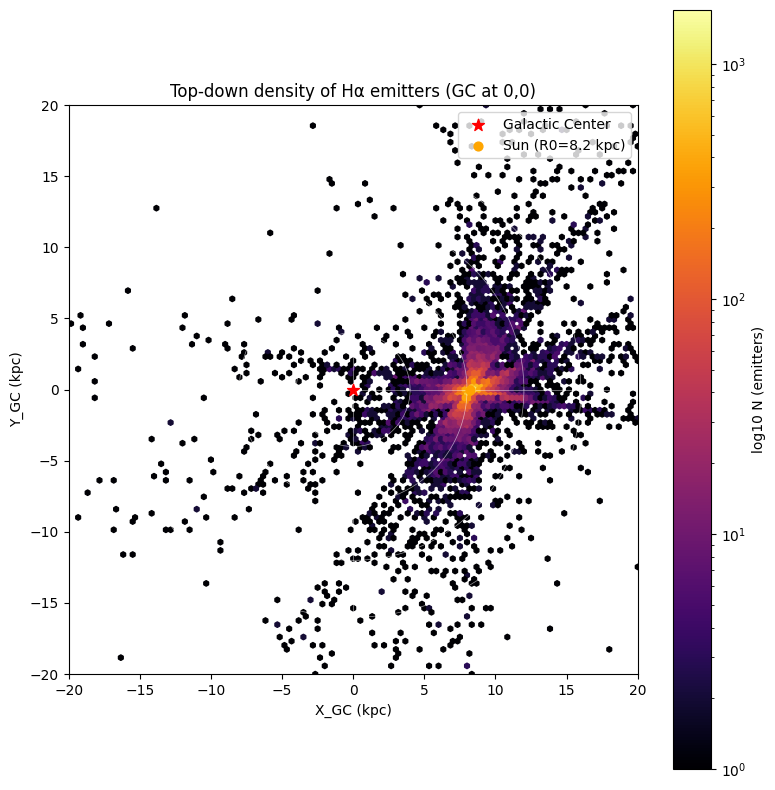

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

df = emitters.copy()

# --- units & cleaning ---
Xk = (df["X_gc"].to_numpy() / 1000.0)
Yk = (df["Y_gc"].to_numpy() / 1000.0)
finite = np.isfinite(Xk) & np.isfinite(Yk)
Xk, Yk = Xk[finite], Yk[finite]

# --- choose a sensible window around GC ---
Rk = np.hypot(Xk, Yk)
Rmax = np.percentile(Rk, 99)            # robust radius
lim = min(20.0, max(8.0, float(Rmax)))  # keep between 8 and 20 kpc
extent = [-lim, lim, -lim, lim]

# --- finer grid based on sample size ---
N = Xk.size
gridsize = int(np.clip(np.sqrt(N)/2, 120, 500))  # 120–500 is a good range

plt.figure(figsize=(8,8))

hb = plt.hexbin(
    Xk, Yk,
    gridsize=gridsize,
    extent=extent,
    bins='log',              # log10 counts
    mincnt=1,                # mask empty bins
    cmap='inferno'
)
cbar = plt.colorbar(hb)
cbar.set_label('log10 N (emitters)')

# Reference circles
for r in [4, 8, 12, 16, 20]:
    if r < lim:
        th = np.linspace(0, 2*np.pi, 360)
        plt.plot(r*np.cos(th), r*np.sin(th), color='white', lw=0.5, alpha=0.6)

# GC and Sun markers
R0, Zsun = 8.2, 0.02
plt.scatter(0, 0, s=80, marker='*', color='red', label='Galactic Center', zorder=3)
plt.scatter(R0, 0, s=40, color='orange', label=f'Sun (R0={R0:.1f} kpc)', zorder=3)

plt.xlabel('X_GC (kpc)')
plt.ylabel('Y_GC (kpc)')
plt.title('Top-down density of Hα emitters (GC at 0,0)')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(extent[0], extent[1])
plt.ylim(extent[2], extent[3])
plt.axhline(0, color='white', lw=0.5, alpha=0.6)
plt.axvline(0, color='white', lw=0.5, alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()